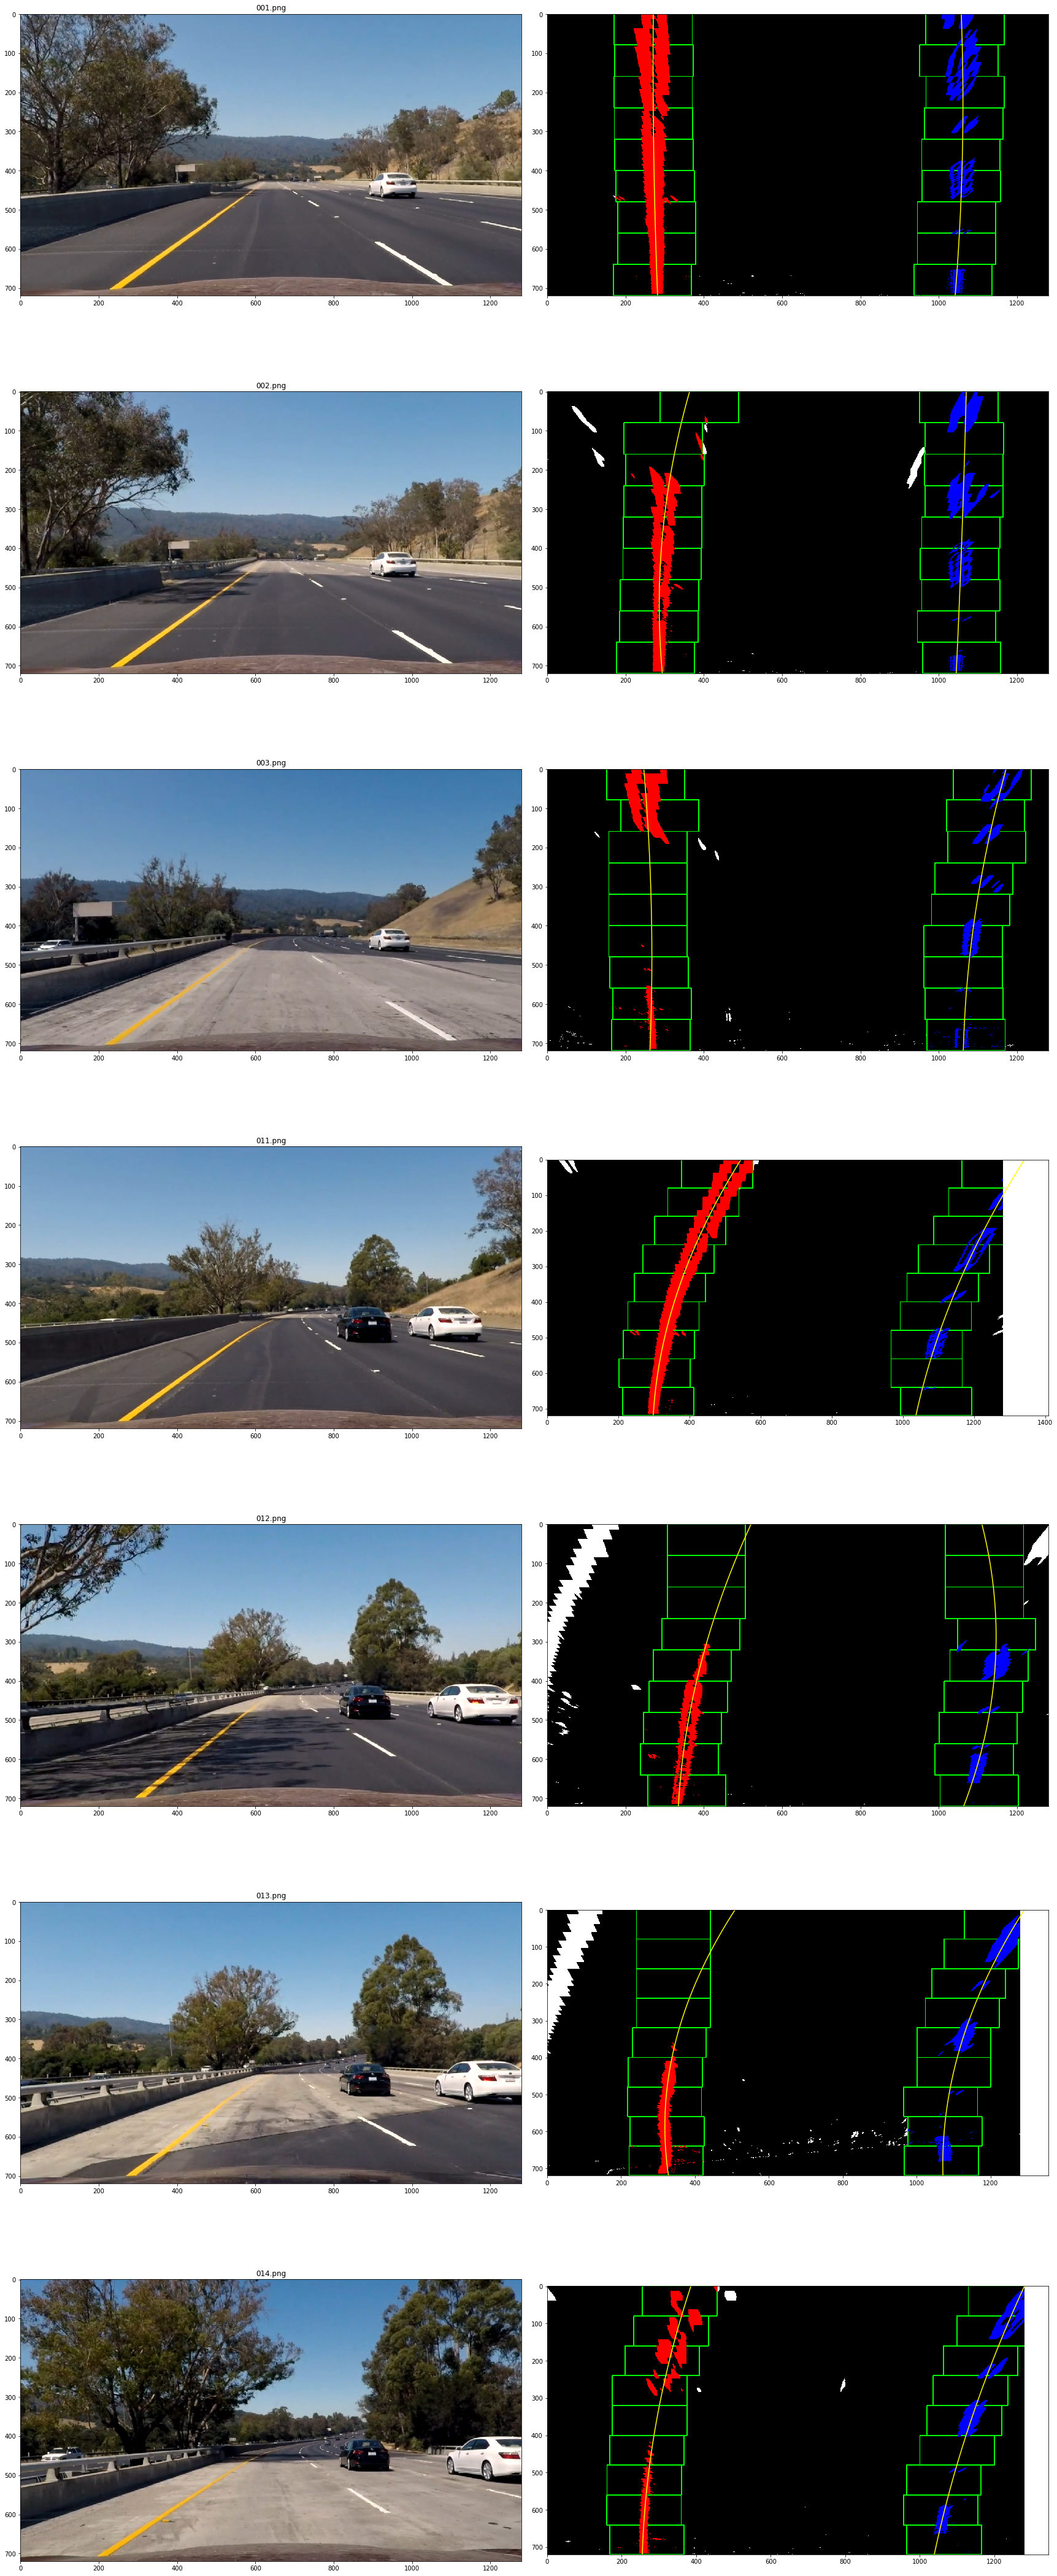

In [1]:
%matplotlib inline

import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
from calibrate_camera import get_calibration_data, undistort_image
from glob import glob
from thresholds import get_abs_sobel_thresh, get_magnitude_threshold, get_direction_threshold, get_color_threshold
from warper import get_dst_pts, get_src_pts, warper


COLUMNS=2

calibration = get_calibration_data()
matrix = calibration['mtx']
distortion_coefficients = calibration['dist']

images = glob('./trouble_spot_images/*.png')
rows = len(images)

f, ax = plt.subplots(rows, COLUMNS, figsize=(24, 60))
f.tight_layout()

for idx, image_filename in enumerate(images):
    current_col = abs(idx % COLUMNS - 1)
    image = cv2.cvtColor(cv2.imread(image_filename), cv2.COLOR_BGR2RGB)
    undistorted = undistort_image(image, matrix, distortion_coefficients)
    _, combined_binary = get_color_threshold(undistorted)
    
    combined_binary_img_size = (combined_binary.shape[1], combined_binary.shape[0])
    src = get_src_pts()
    dst = get_dst_pts()
    binary_warped = warper(combined_binary, src, dst)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
#     print('midpoint = {}'.format(midpoint))
#     print('leftx_base = {}  rightx_base = {}'.format(leftx_base, rightx_base))

    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - ((window + 1) * window_height)
        win_y_high = binary_warped.shape[0] - (window * window_height)
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2) 
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & 
                          (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & 
                          (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & 
                           (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & 
                           (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    ax[idx, 0].imshow(undistorted)
    ax[idx, 0].set_title(image_filename.split('/')[-1])

    ax[idx, 1].imshow(out_img)
    ax[idx, 1].plot(left_fitx, ploty, color='yellow')
    ax[idx, 1].plot(right_fitx, ploty, color='yellow')
#     ax[idx, 1].xlim(0, 1280)
#     ax[idx, 1].ylim(720, 0);

In [2]:
image = cv2.imread('./trouble_spot_images/001.png')
print(image.shape) 


(720, 1280, 3)
